# FXP capital account parsing

#### Necessary libraries

In [1]:
import os
import camelot
import pandas as pd
import re

In [2]:
# Source of PDFs
pdf_dir = r"C:\Users\ArtemPetrushin\Servc\FXP - General\Financial Statements\2025\2025 Q2\CA pdf"

# Results output
output_dir = r"C:\Users\ArtemPetrushin\Desktop\Pithon"

#### Variables to store results of parsing

In [3]:
# List to store all the dataframes with balances from the body of the document. We'll concatenate them in the end
all_tables = []

# Dataframe with investors' name checks
df_check_investors = pd.DataFrame(columns=['Investor ID in PDF file name',
                                           'Investor ID in the document',
                                           'Match',
                                           'Investor name'])

# Dataframe with balance checks
df_check_results = pd.DataFrame(columns=['PDF file name',
                                         'Balance lines #',
                                         'Year-to-date',
                                         'Inception-to-date',
                                         'Difference'])

# Dataframe with balance checks
df_check_contribution = pd.DataFrame(columns=['PDF file name',
                                         'Commitment',
                                         'Contribution',
                                         'Called',
                                         'Contribution minus called',
                                        'Uncalled',
                                        'Commitment minus Contribution minus Uncalled'])

#### Common functions

In [4]:
# Function to convert numbers in financial format to numeric
def convert_value(value):
    """
    Convert financial format string into numeric:
    1. Dash (-) → 0.0
    2. (number) → negative number
    3. number,number → number (deletes commas)
    4. In other cases standard conversion to float
    """
    # Replacing dash
    if isinstance(value, str) and value.strip() == '-':
        return 0.0

    # NaN to float
    if pd.isna(value):
        return float('nan')  # returns Nan as a float

    if isinstance(value, str):
        value = value.strip()  # deletes spaces on both sides of the text

        # Converting numbers in brackets including with commas
        if re.fullmatch(r'\([\d,]+\)', value):
            num = value.replace(',', '').strip('()')
            try:
                return -float(num)
            except ValueError:
                pass

        # Converting numbers with commas
        elif re.fullmatch(r'[\d,]+', value):
            try:
                return float(value.replace(',', ''))
            except ValueError:
                pass

    # Trying to convert to float with a standard method
    try:
        return float(value)
    except (ValueError, TypeError):
        return float('nan')


# Function to split one column in dataframe into two. It will be necessary to extract investor's name.
def split_column_by_colon(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Splits a specified DataFrame column into two new columns based on the 
    first occurrence of a colon.

    This function creates two new columns named '{original_name}_key' and 
    '{original_name}_value'. Values in the new columns are stripped of any
    leading or trailing whitespace. The original column is then dropped.

    Args:
        df (pd.DataFrame): The input DataFrame to process.
        column_name (str): The name of the column to be split.

    Returns:
        pd.DataFrame: A new DataFrame with the specified column replaced by 
                      two new columns ('_key' and '_value').
    
    Raises:
        KeyError: If a column with the specified name does not exist in the DataFrame.
    """
    if column_name not in df.columns:
        raise KeyError(f"Column '{column_name}' not found in the DataFrame.")

    # Create a copy to avoid modifying the original DataFrame outside the function
    df_copy = df.copy()

    # 1. Split the column into two parts based on the first colon.
    #    expand=True creates a new DataFrame from the split parts.
    #    n=1 ensures the split happens only at the first occurrence of ':'
    split_data = df_copy[column_name].str.split(':', n=1, expand=True)

    # 2. Create names for the new columns
    new_col_key = 100
    new_col_value = 101
    
    # 3. Assign the split data to the new columns in our DataFrame.
    #    Also, apply .str.strip() to remove any leading/trailing whitespace.
    df_copy[new_col_key] = split_data[0].str.strip()
    
    # Handle the second column, which might contain None (or NaN) if no colon 
    # was found in the original string.
    df_copy[new_col_value] = split_data[1].str.strip()

    # 4. Drop the original column
    df_copy = df_copy.drop(columns=[column_name])

    return df_copy

# Function to filter dataframe based on the firs and last rows' names.
# It will be used to extract balance from the report and capital
def filter_dataframe(df, first_row, last_row):
    """
    Filters a DataFrame based on a start and end row value, 
    and returns an independent copy of the filtered data.
    """
   
    first_row = str(first_row)
    last_row = str(last_row)    
    
    # Find the indices of the first and last rows
    try:
        start_idx = df[df[0] == first_row].index[0]
        end_idx = df[df[0] == last_row].index[0]
    except IndexError:
        print(f"Error: Could not find row '{first_row}' or '{last_row}'. Please check the data.")
        # Return an empty DataFrame with the same columns to avoid errors downstream
        return pd.DataFrame(columns=df.columns)

    print("start df: ", start_idx, "end df: ", end_idx)

    # Select the slice using .loc and IMMEDIATELY create a copy of it using .copy()
    filtered_slice = df.loc[start_idx:end_idx]
    
    return filtered_slice.copy()

#### Extracting the main table

Processing file: 7777-01-002_CA_Q2_2025.pdf
start df:  2 end df:  9
Value of 'Total capital commitment' is found: 20000000.0
Value of 'Contribution' is found: 12930000.0
Value of 'Capital called' is found: 12930000.0
Value of 'Uncalled capital commitment' is found: 7070000.0
Processing file: 7777-01-003_CA_Q2_2025.pdf
start df:  2 end df:  9
Value of 'Total capital commitment' is found: 3000000.0
Value of 'Contribution' is found: 1939500.0
Value of 'Capital called' is found: 1939500.0
Value of 'Uncalled capital commitment' is found: 1060500.0
Processing file: 7777-01-004_CA_Q2_2025.pdf
start df:  2 end df:  9
Value of 'Total capital commitment' is found: 250000.0
Value of 'Contribution' is found: 161625.0
Value of 'Capital called' is found: 161625.0
Value of 'Uncalled capital commitment' is found: 88375.0
Processing file: 7777-01-005_CA_Q2_2025.pdf
start df:  2 end df:  9
Value of 'Total capital commitment' is found: 500000.0
Value of 'Contribution' is found: 323250.0
Value of 'Capital

C:\Users\ArtemPetrushin\anaconda3\envs\camelot_env\lib\site-packages\camelot\plotting.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


start df:  2 end df:  9
Value of 'Total capital commitment' is found: 75000.0
Value of 'Contribution' is found: 48488.0
Value of 'Capital called' is found: 48488.0
Value of 'Uncalled capital commitment' is found: 26512.0
Processing file: 7777-01-024_CA_Q2_2025.pdf
start df:  2 end df:  9
Value of 'Total capital commitment' is found: 50000.0
Value of 'Contribution' is found: 32325.0
Value of 'Capital called' is found: 32325.0
Value of 'Uncalled capital commitment' is found: 17675.0
Processing file: 7777-01-025_CA_Q2_2025.pdf
start df:  2 end df:  9
Value of 'Total capital commitment' is found: 50000.0
Value of 'Contribution' is found: 32325.0
Value of 'Capital called' is found: 32325.0
Value of 'Uncalled capital commitment' is found: 17675.0
Processing file: 7777-01-026_CA_Q2_2025.pdf
start df:  2 end df:  9
Value of 'Total capital commitment' is found: 150000.0
Value of 'Contribution' is found: 96975.0
Value of 'Capital called' is found: 96975.0
Value of 'Uncalled capital commitment' i

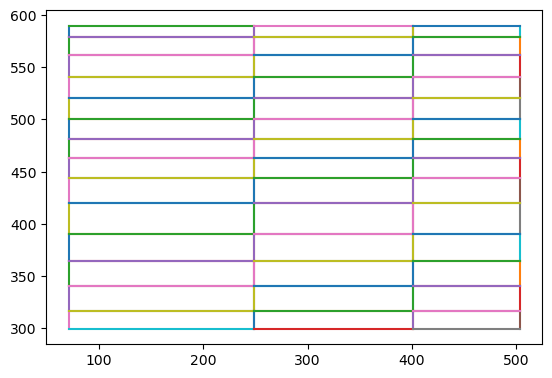

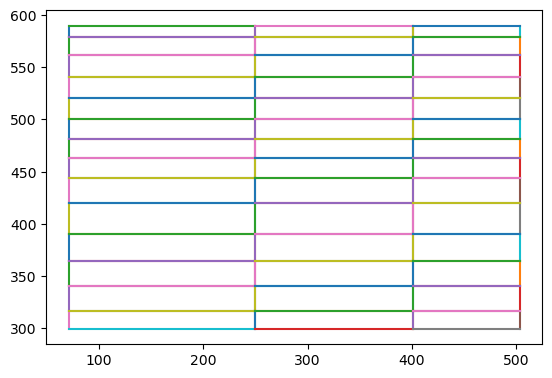

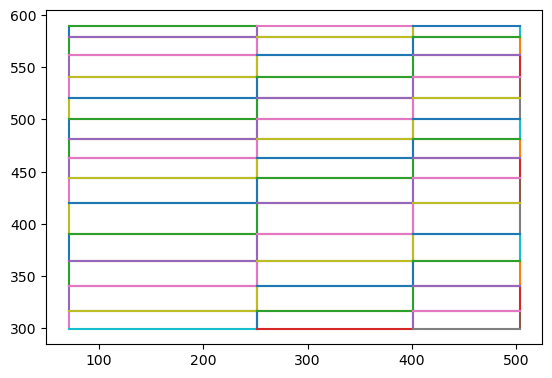

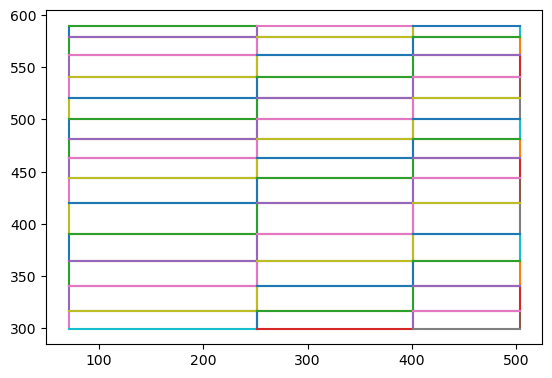

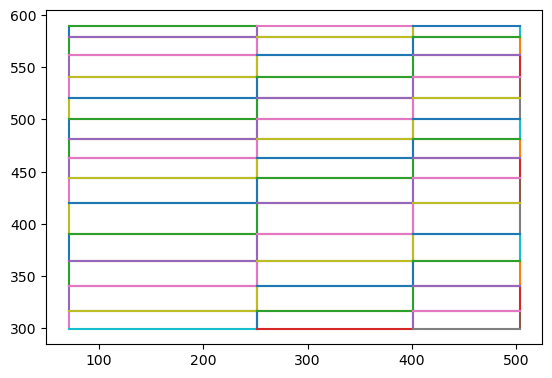

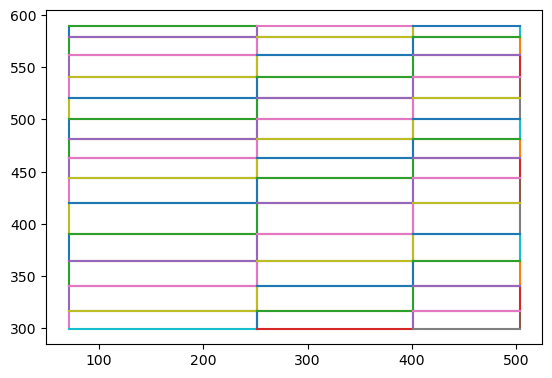

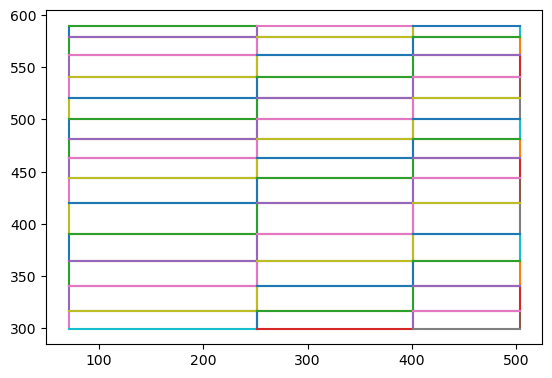

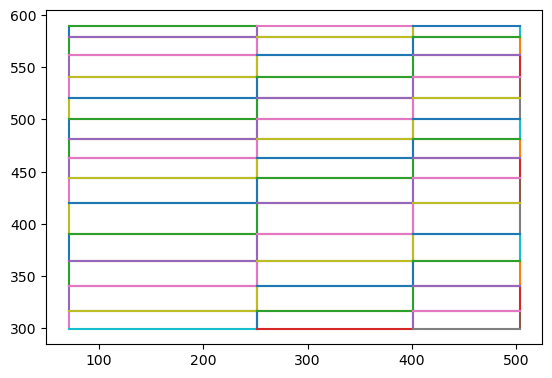

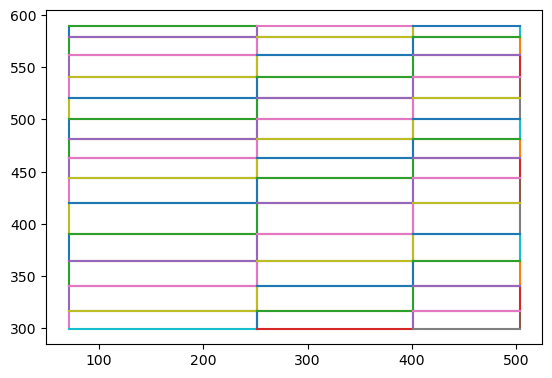

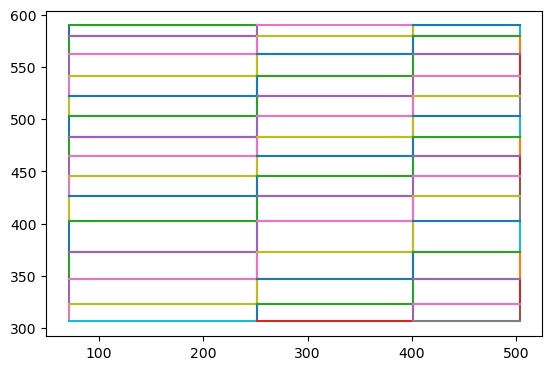

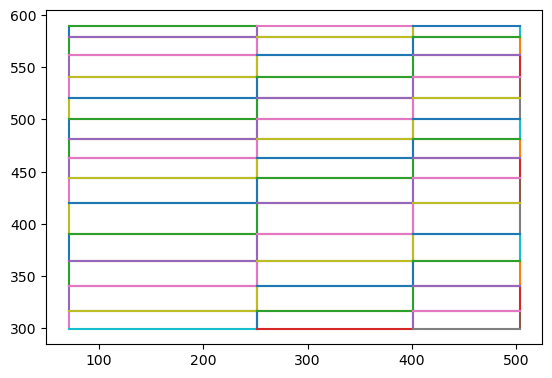

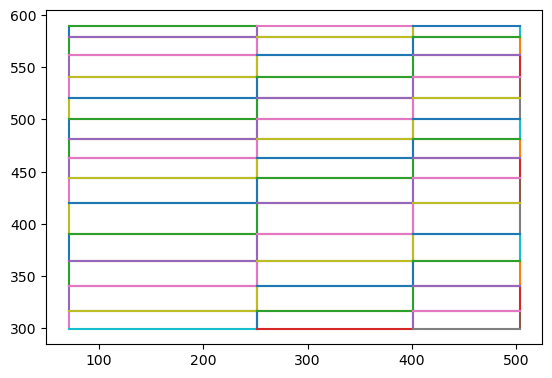

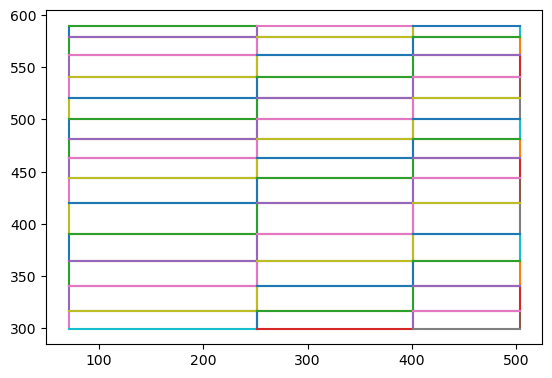

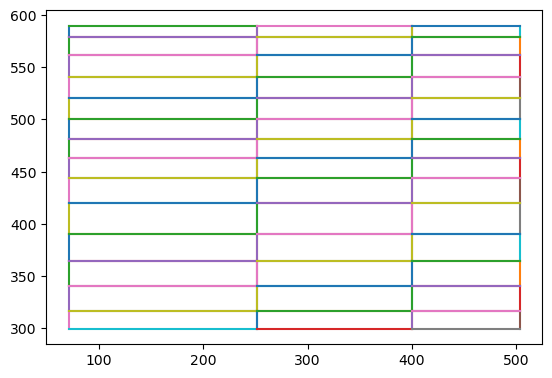

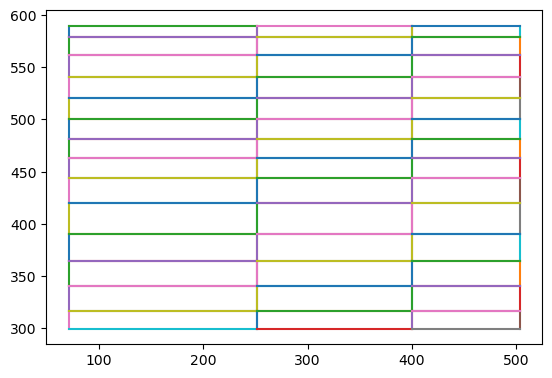

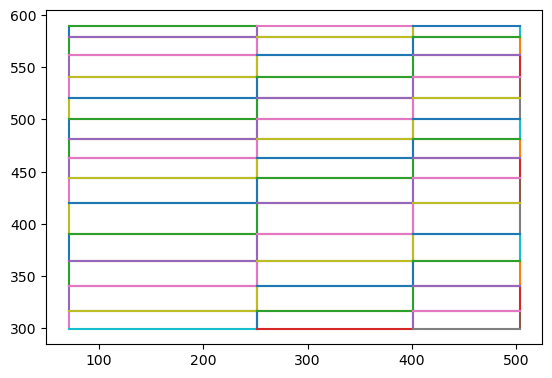

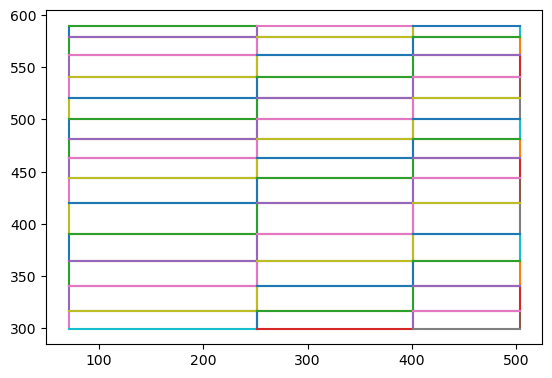

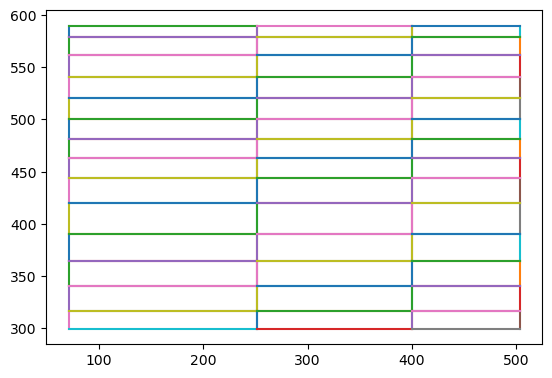

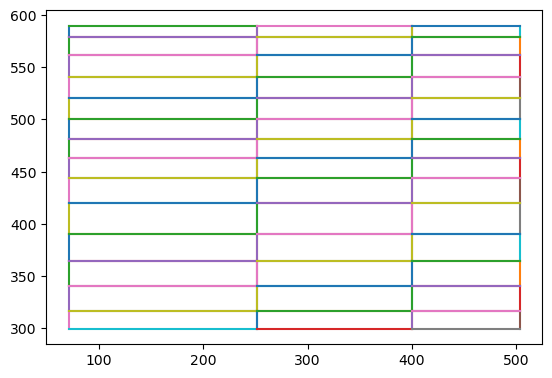

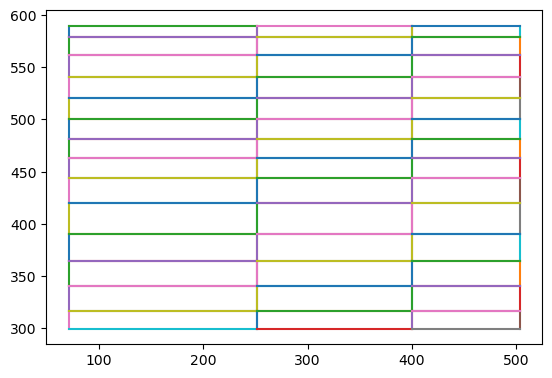

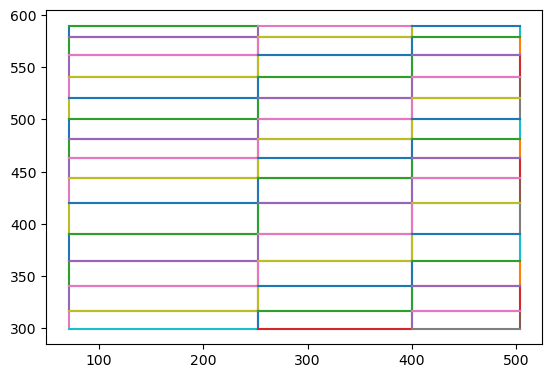

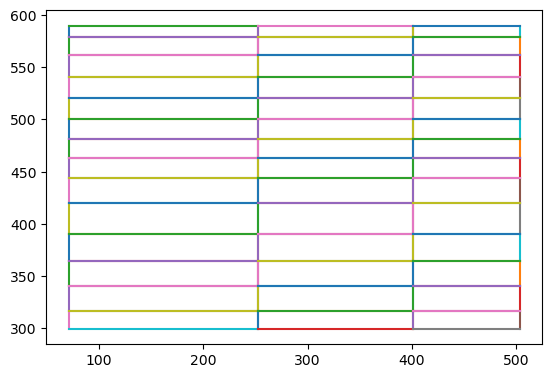

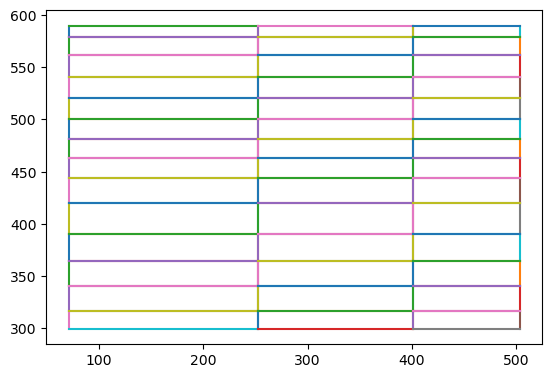

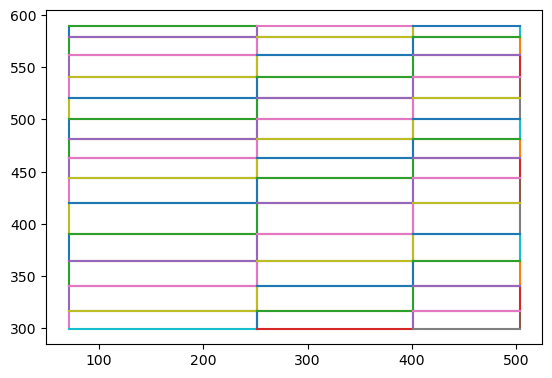

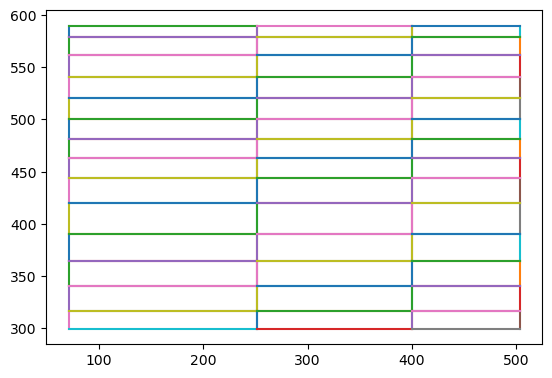

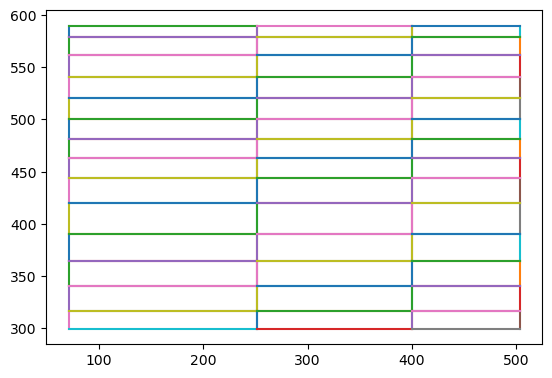

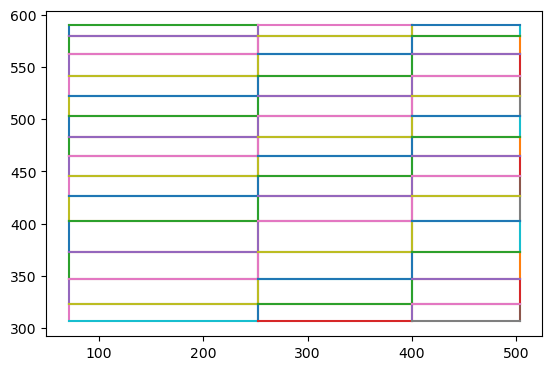

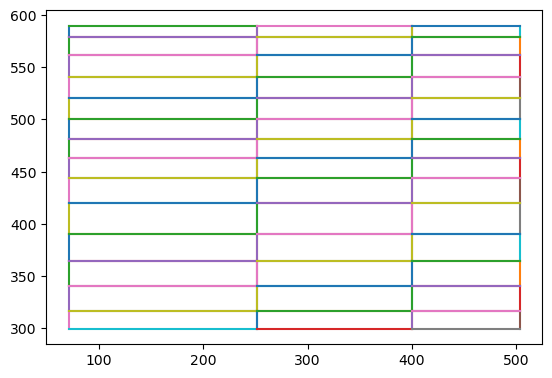

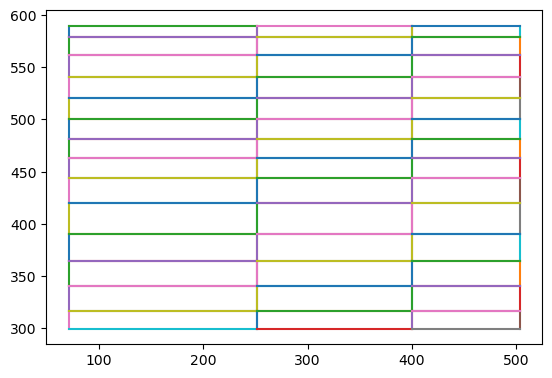

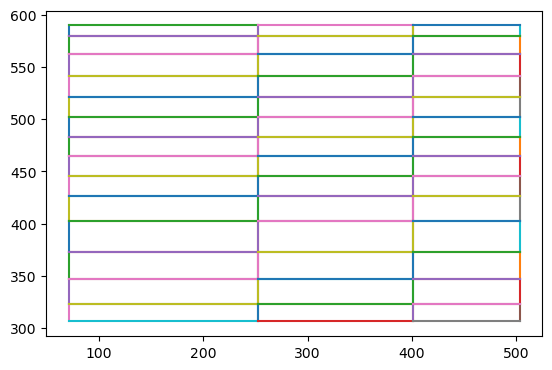

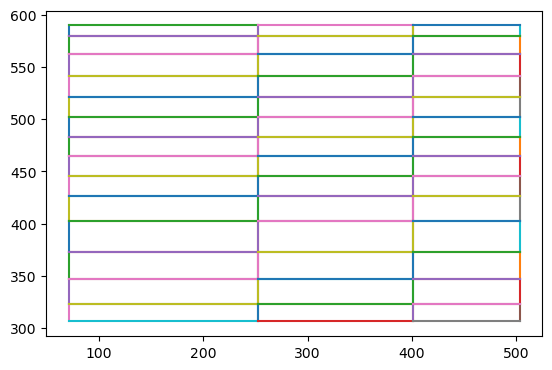

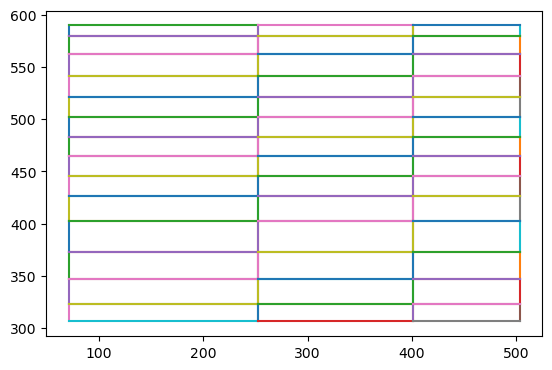

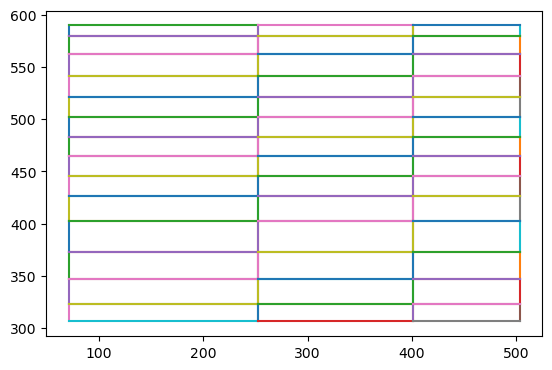

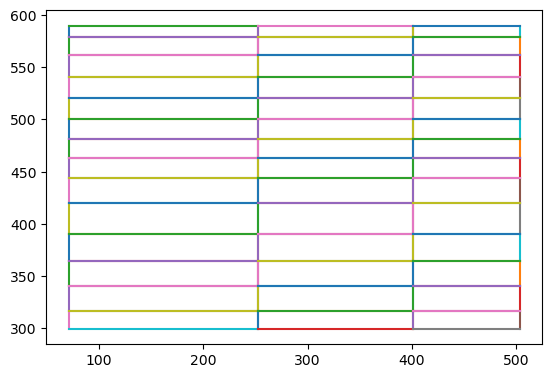

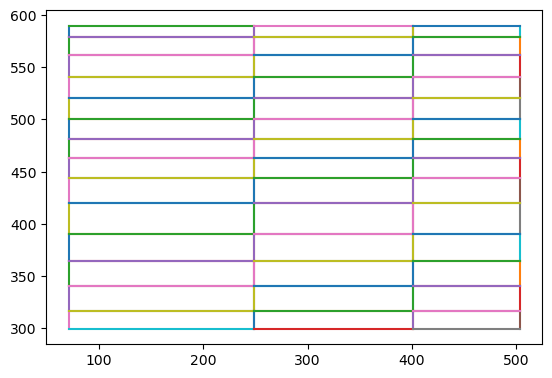

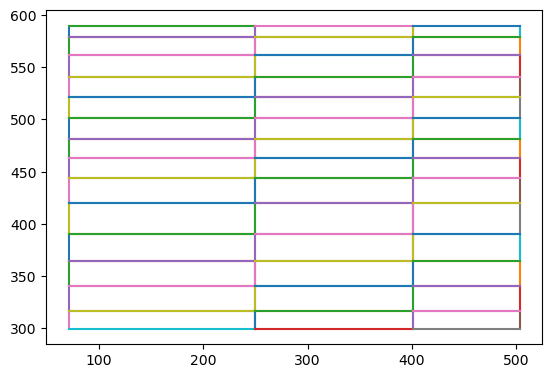

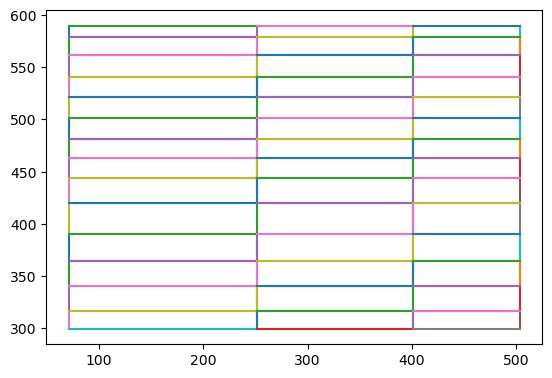

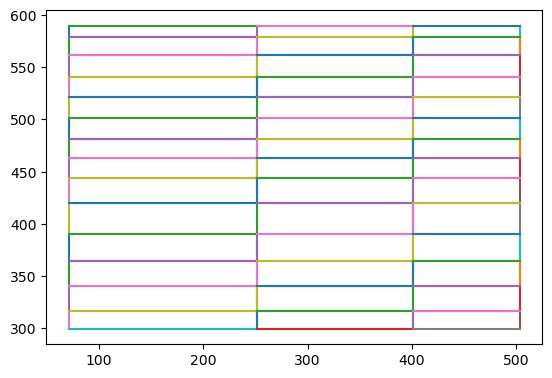

In [ ]:
for pdf_file in os.listdir(pdf_dir):
    pdf_path = os.path.join(pdf_dir, pdf_file)
    print(f"Processing file: {pdf_file}")
    # extracting file prefix to use in cycles below
    file_prefix = os.path.splitext(pdf_file)[0]

    try:
        tables = camelot.read_pdf(pdf_path, 
                                  pages='1', 
                                  flavor='stream',
                                 table_areas = ['80,590,580,300'])
        
        # Preview
        if tables:            
            # Получаем данные в виде DataFrame pandas
            df_balance = tables[0].df
            # print("Extracted balance:")
            # display(df_balance) # display() лучше отображает таблицы в Jupyter
        else:
            print("Tables in the area have not been found.")

        # Converting financial type of data into numeric format
        df_balance.loc[:, 1] = df_balance[1].apply(convert_value)
        df_balance.loc[:, 2] = df_balance[2].apply(convert_value)

        # Uncomment to display PDF image
        # display(df_balance)
        
        #Filtering a dataframe with extracted balance
        df_filtered_balance = filter_dataframe(df_balance,
                                               'Balance, beginning of period',
                                               'Balance, end of period')
        # #Filtering a dataframe with capital commitment
        # df_filtered_capital_commitment = filter_dataframe(df_balance,
        #                                        'Capital called',
        #                                        'Uncalled capital commitment')
    
        # Convert values in columns 2 and 3 into numeric format
        df_filtered_balance.loc[:, 1] = df_filtered_balance[1].apply(convert_value)
        df_filtered_balance.loc[:, 2] = df_filtered_balance[2].apply(convert_value)
    
        # python calculated sum
        col1_sum = df_filtered_balance[1][:-1].sum()
        col2_sum = df_filtered_balance[2][:-1].sum()
    
        # the existing sum in the line "Balance, end of period"
        col1_value = df_filtered_balance[1].iloc[-1]
        col2_value = df_filtered_balance[2].iloc[-1]
    
        # Calculating the sum of given values and subtracting the calculated results
        balance_check = col1_value + col2_value - col1_sum - col2_sum
    
        final_row = [balance_check, col1_sum, col2_sum]
    
        df_filtered_balance.loc[len(df_filtered_balance)+3] = final_row
    
        if balance_check != 0:
            print ("Check balances!")
    
        # Rename columns: file name & column number
        file_prefix = os.path.splitext(pdf_file)[0]  # exclude extension .pdf
        df_filtered_balance.columns = [f"{file_prefix}_col{i+1}" for i in range(len(df_filtered_balance.columns))]
    
        # Making a list of all dataframes to save them after in one excel tab
        all_tables.append(df_filtered_balance)

        # Creating a row with checks results to save them after as a summary of checks
        # It contains: name of the file, number of lines in the first column, year-to-date balance,
        # inception-to-date balance, difference of the last two items
        result_row = [file_prefix, df_filtered_balance.shape[0]-1,col1_sum,col2_sum,balance_check]
        
        # Appending the dataframe with summary of checks
        # df_check_results.append(result_row)
        df_check_results.loc[len(df_check_results)] = result_row

        # print(df_balance.head(5))

        # Commitment key words to extract information
        keywords = ['Total capital commitment', 'Contribution', 'Capital called', 'Uncalled capital commitment']
        
        # Dictionary to store
        extracted_values = {}
        
        keyword_col_index = 0
        value_col_index = 2

        # Cycle to go through keywords
        for word in keywords:
            try:
                # Ищем строку, где значение в первой колонке (iloc[:, 0]) содержит искомое слово.
                # .str.contains(word, na=False) - надежный способ поиска подстроки.
                row = df_balance[df_balance.iloc[:, keyword_col_index].str.contains(word, na=False, case=False)]
        
                if not row.empty:
                    # Если строка найдена, берем из нее значение из третьей колонки (iloc[:, 2])
                    value = row.iloc[0, value_col_index]
                    extracted_values[word] = value
                    print(f"Value of '{word}' is found: {value}")
                else:
                     # Этот блок сработает, если слово не найдено
                     print(f"'{word}' has not been found in {keyword_col_index}.")
                     extracted_values[word] = None
        
            except IndexError:
                # This error may raise if there are less than 3 columns in dataframe
                print(f"Index error: make sure the dataframe contains at least {value_col_index + 1} columns.")
                extracted_values[word] = None
            except Exception as e:
                # Other unexpected errors
                print(f"Unexpected error while searching for '{word}': {e}")
                extracted_values[word] = None

        # Key words for search should match the key words above
        total_commitment = extracted_values.get('Total capital commitment')
        contribution_value = extracted_values.get('Contribution')    
        called_value = extracted_values.get('Capital called')
        uncalled_value = extracted_values.get('Uncalled capital commitment')
        contribution_minus_called = contribution_value - called_value
        final_check = total_commitment - called_value - uncalled_value

        commitment_row = [file_prefix,
                          total_commitment,
                        contribution_value,
                        called_value,
                        contribution_minus_called,
                        uncalled_value,
                        final_check]
    
        df_check_contribution.loc[len(df_check_contribution)] = commitment_row
        
    except Exception as e:
        print(f"Error while processing {pdf_file}: {str(e)}")

#### Extracting investor's name and ID

Processing file: 7777-01-002_CA_Q2_2025.pdf

              1                   2                100               101
0                  September 03, 2025  Investor's name  Insight FXP, LLC
1                                        Investor's ID       7777-01-002
2  FXP FUND 1, LP                                                   None

Processing file: 7777-01-003_CA_Q2_2025.pdf

                  1                100                             101
0  September 03, 2025  Investor's name  Teach a man to fish foundation
1                        Investor's ID                     7777-01-003
2                       FXP FUND 1, LP                            None

Processing file: 7777-01-004_CA_Q2_2025.pdf

              1                   2                100                    101
0                  September 03, 2025  Investor's name  Quantum Angels II LLC
1                                        Investor's ID            7777-01-004
2  FXP FUND 1, LP                                    

C:\Users\ArtemPetrushin\anaconda3\envs\camelot_env\lib\site-packages\camelot\plotting.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()



                  1                100  \
0  September 03, 2025  Investor's name   
1                        Investor's ID   
2                       FXP FUND 1, LP   

                                                 101  
0  The de Luna 2010 Living Trust dated July 15, 2010  
1                                        7777-01-022  
2                                               None  

Processing file: 7777-01-024_CA_Q2_2025.pdf

              1                   2                100          101
0                  September 03, 2025  Investor's name   Eyal Levin
1                                        Investor's ID  7777-01-024
2  FXP FUND 1, LP                                              None

Processing file: 7777-01-025_CA_Q2_2025.pdf

                  1                100                                   101
0  September 03, 2025  Investor's name  Rachael McCarthy and Thomas McCarthy
1                        Investor's ID                           7777-01-025
2              

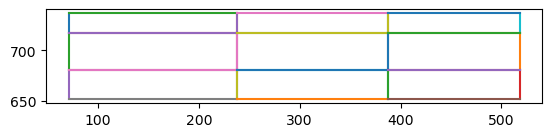

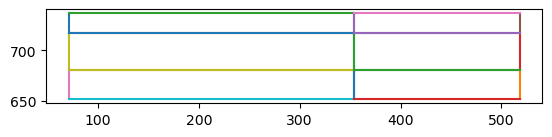

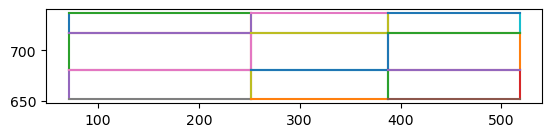

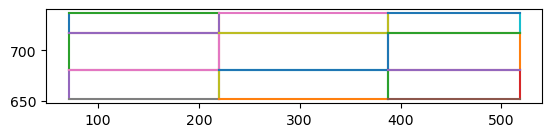

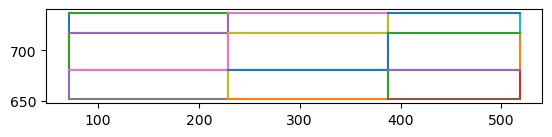

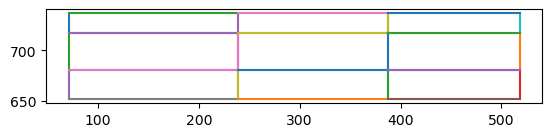

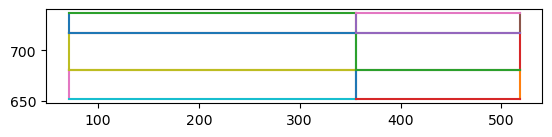

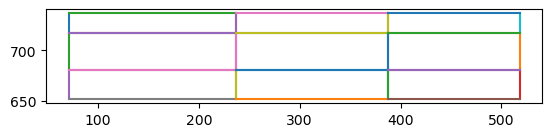

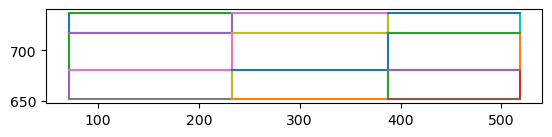

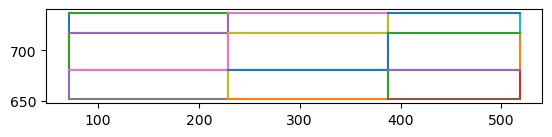

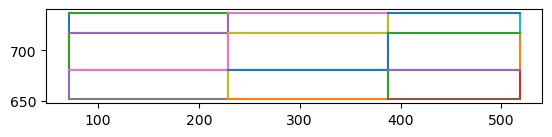

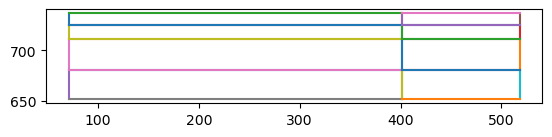

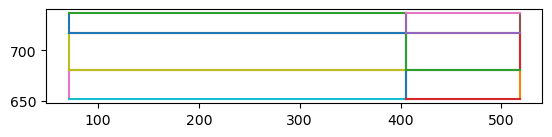

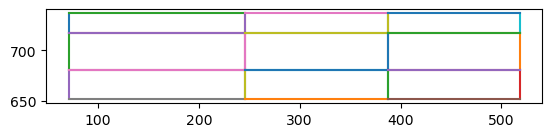

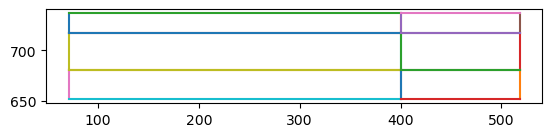

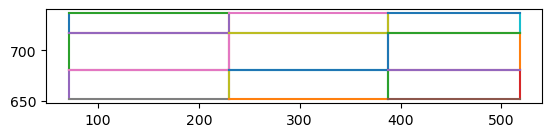

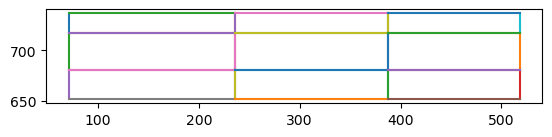

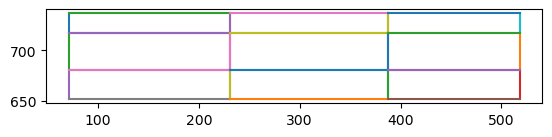

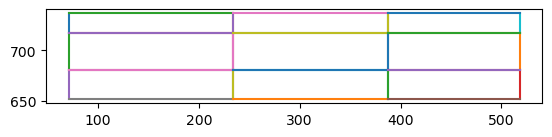

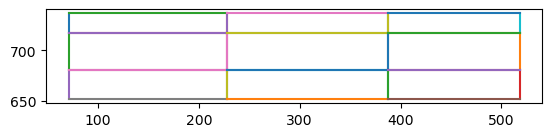

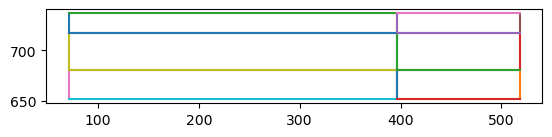

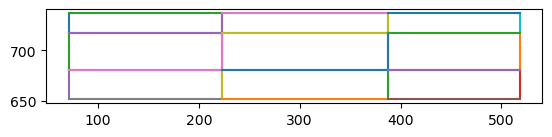

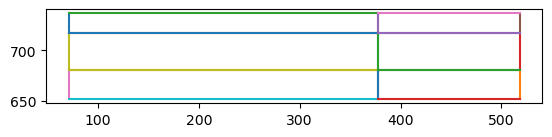

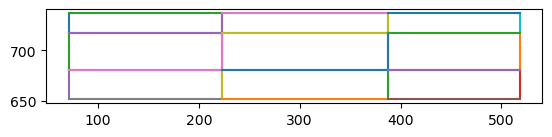

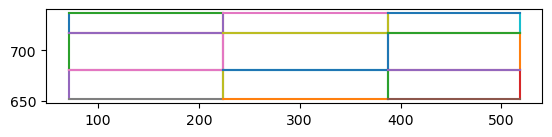

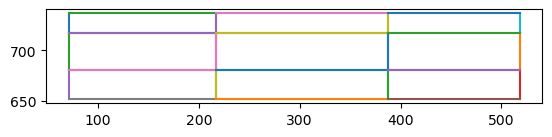

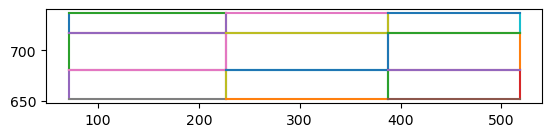

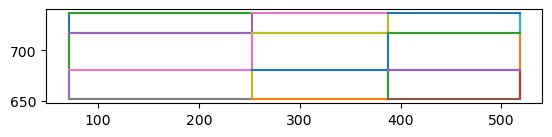

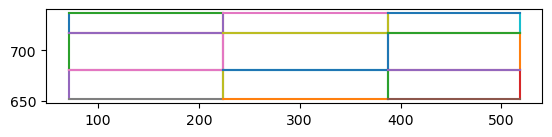

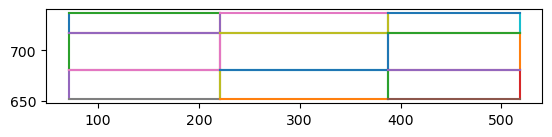

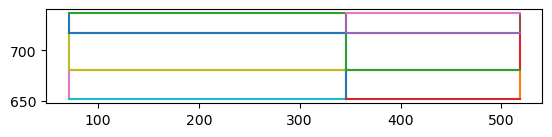

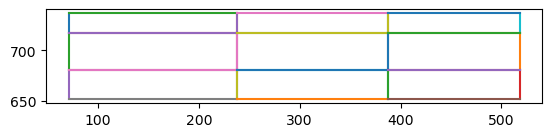

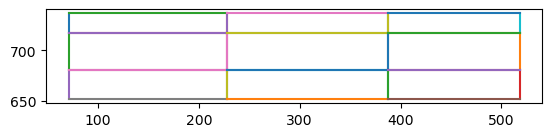

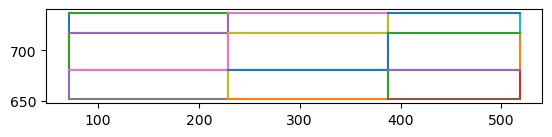

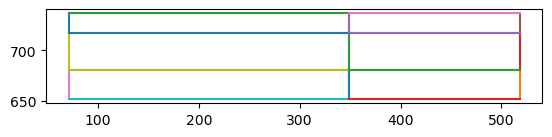

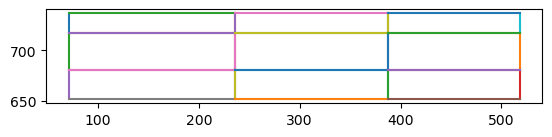

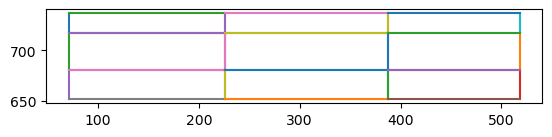

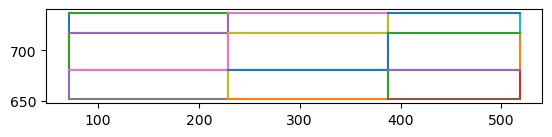

In [ ]:
for pdf_file in os.listdir(pdf_dir):
    pdf_path = os.path.join(pdf_dir, pdf_file)
    print(f"Processing file: {pdf_file}")
    # extracting file prefix to use in cycles below
    file_prefix = os.path.splitext(pdf_file)[0]

    try:
        investor_tables = camelot.read_pdf(pdf_path, 
                                  pages='1', 
                                  flavor='stream',
                                 table_areas = ['100,750,500,650'])
        if investor_tables:
            df_investor = investor_tables[0].df
            # print("Extracted information on investor:")
            # print(df_investor)

            df_investor_ID = split_column_by_colon(df_investor,0)
            print()
            print(df_investor_ID)
            print()

            # Collecting results of investors checks in 1 list to include in dataframe afterwards to export
            # We compare 11 symbols in the file name to the value inside the document
            investor_result_row = [
                file_prefix[:11],
                df_investor_ID.at[1,101],
                file_prefix[:11] == df_investor_ID.at[1,101],
                df_investor_ID.at[0, 101]
            ]

            # Inserting investor check in the dataframe
            df_check_investors.loc[len(df_check_investors)] = investor_result_row
            
        else:
            print("Info on investor has not been found in the specified area.")
            # Dataframe for the investor ID
    except Exception as e:
        print(f"Error while parsing investor's name part of the document {pdf_file}: {str(e)}")

In [7]:
# Concatenate dataframes into one
merged_df = pd.concat(all_tables, axis=1)
output_path = os.path.join(output_dir, "FXP_merged_tables.xlsx")

# Check if the excel file we try to write exists already
if not os.path.exists(output_path):
    # Create a file with a sheet in it
    with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
        pd.DataFrame().to_excel(writer, sheet_name="Sheet")

with pd.ExcelWriter(output_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    merged_df.to_excel(writer, sheet_name="merged_tables", index=False)
    df_check_results.to_excel(writer, sheet_name="checks_summary", index=False)
    df_check_investors.to_excel(writer, sheet_name="checks_investors", index=False)
    df_check_contribution.to_excel(writer, sheet_name="contribution_check", index=False)

print("Result has been saved: ",output_path)

Result has been saved:  C:\Users\ArtemPetrushin\Desktop\Pithon\FXP_merged_tables.xlsx
